In [119]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2 as cv
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [161]:
# base_path = 'D:/AI Courses/Semester 3/Hardware Technologies for AI/Project/Operational Data/'
# data_path = '/Small Data Set/Small set data/'
# imgs_path = '/Small Data Set/Small set images/'
headers_path = './Data Column Headings.csv'
# labels_path = 'Small Data Set Labels-1.xlsx'
df_path = 'Small Data Set.csv'

In [162]:
headers = pd.read_csv(headers_path)
df = pd.read_csv(df_path)
# imgs = os.listdir(base_path + imgs_path)

# csv_dirs = [base_path + data_path + each[:-4] + '.csv' for each in imgs]
# imgs = [base_path + imgs_path + each for each in imgs]

# lbls = pd.read_excel(labels_path)
# lbls.dropna(inplace=True)
# df_dict = {'Images': imgs, 'Data': csv_dirs}
# df = pd.DataFrame(df_dict)
# df['Labels'] = lbls['No. of Axis'].astype(int).tolist()

In [156]:
# df['Images'] = df['Images'].str.extract(pat='([a-zA-Z0-9/\s:]+.jpg)').dropna()[0]

In [163]:
df

,Images,Data,Labels
0,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,7
1,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,6
2,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,7
3,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,7
4,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,3
...,...,...,...
93,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,5
94,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,6
95,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,6
96,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,5


In [118]:
rcnn = models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
rcnn.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RESIZE = 448
BATCH_SIZE = 16
SPLIT_PERCENT = 0.75

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [62]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        # transforms.GaussianBlur((19, 19)),
        # transforms.RandomAffine(0, shear=10, scale=(0.9,1.1)),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        normalize
    ]),
    'other':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        # transforms.GaussianBlur((19, 19)),
        transforms.ToTensor(),
        normalize
    ]),
    'rcnn':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        # transforms.GaussianBlur((19, 19)),
        transforms.ToTensor(),
        # normalize
    ]),
    'rcnn_v':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        # transforms.ToTensor(),
        # normalize
    ])
}

In [132]:
def extract_trucks(model, img, transform=None):

    model.eval()
    img_rcnn = data_transforms['rcnn'](img)
    img_v = np.array(data_transforms['rcnn_v'](img))
    c, w, h = img_rcnn.shape

    res = model(img_rcnn.reshape((1, c, w, h)))
    bboxes, lbls = res[0]['boxes'].detach(), res[0]['labels']
    bboxes = [np.array(each, dtype=int) for each in bboxes]
    bboxes = np.array(bboxes)

    trucks_bboxs = []

    for i, each_lbl in enumerate(lbls):
        if each_lbl == 8:
            trucks_bboxs.append(bboxes[i])

    if len(trucks_bboxs) >= 0:
        max_wh = 0
        max_wh_id = 0
    
        for i, (x, y, a, b) in enumerate(trucks_bboxs):
            w = a - x
            h = b - y
        
            if w + h > max_wh:
                max_wh = w + h
                max_wh_id = i
    
    
        truck = trucks_bboxs[max_wh_id]

        img_crop = img_v[truck[1]: truck[3], truck[0]: truck[2]]
    
    else:
        img_crop = img_v

    if transform:
        img_crop = transform(Image.fromarray(img_crop))

    return img_crop

In [77]:
# def extract_strains(data):
    
exmpl_strain_path = df.iloc[2][1]

In [101]:
csv_file = pd.read_csv(exmpl_strain_path)
csv_file.columns = headers.columns

In [111]:
csv_file

,Date,Sample_Number,Sum of strains mid span,G19,G22,G25,G28,G7,G10,G13,...,G5,G2,G4,G6,G31,G32,TC1,TC2,TC3,TC4
0,20170501.0,-999.0,-1.4,-0.1,0.3,-1.0,-0.7,0.1,0.3,0.8,...,-0.6,0.0,0.2,-0.5,-0.2,0.0,14.2,15.1,14.7,16.8
1,20170501.0,-998.0,-1.8,-0.2,0.0,-0.9,-0.8,0.1,0.2,0.4,...,-0.6,0.3,-0.1,-0.7,-0.2,0.0,14.2,15.1,14.7,16.8
2,20170501.0,-997.0,-1.3,-0.0,-0.0,-0.6,-0.7,0.1,-0.1,0.4,...,-0.4,0.3,0.0,-0.3,-0.1,0.0,14.2,15.1,14.7,16.8
3,20170501.0,-996.0,-1.4,-0.2,-0.0,-0.5,-0.6,0.1,-0.2,0.5,...,-0.3,-0.1,-0.1,-0.2,-0.2,0.0,14.2,15.1,14.7,16.8
4,20170501.0,-995.0,-1.4,-0.3,-0.1,-0.4,-0.6,0.1,-0.3,0.0,...,-0.1,0.1,0.3,0.2,0.3,0.0,14.2,15.1,14.7,16.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,20170501.0,995.0,-1.1,-0.5,-0.2,-0.0,-0.3,-0.2,0.5,0.0,...,-0.0,-0.4,0.5,0.7,0.3,0.0,14.2,15.1,14.7,16.8
1995,20170501.0,996.0,-0.8,-0.3,-0.3,-0.1,-0.2,-0.3,0.0,0.2,...,0.3,-0.3,0.4,0.8,0.2,0.0,14.2,15.1,14.7,16.8
1996,20170501.0,997.0,0.2,0.2,-0.1,0.3,-0.2,0.1,-0.1,0.2,...,0.4,-0.4,0.3,0.6,0.0,0.0,14.2,15.1,14.7,16.8
1997,20170501.0,998.0,-0.7,0.2,-0.4,-0.1,-0.4,-0.1,-0.3,-0.0,...,0.1,-0.1,0.3,0.1,-0.1,0.0,14.2,15.1,14.7,16.8


In [113]:
csv_file = csv_file[['Sum of strains mid span', ' TC1', ' TC2', ' TC3', ' TC4']]

In [115]:
arr = torch.from_numpy(np.array(csv_file)).type(torch.float32)
seq_embedder = nn.GRU(5, 128, 1)
res = seq_embedder(arr)

In [116]:
res[0]

tensor([[-0.2815,  0.6482,  0.0718,  ..., -0.1498, -0.3021, -0.5977],
        [-0.4523,  0.8368,  0.1659,  ..., -0.2715, -0.4560, -0.6126],
        [-0.5724,  0.8838,  0.2555,  ..., -0.3766, -0.5238, -0.6001],
        ...,
        [-0.9640,  0.9359,  0.9980,  ..., -0.9957, -0.5689, -0.5453],
        [-0.9641,  0.9363,  0.9980,  ..., -0.9957, -0.5765, -0.5420],
        [-0.9642,  0.9364,  0.9980,  ..., -0.9957, -0.5806, -0.5397]],
       grad_fn=<SqueezeBackward1>)

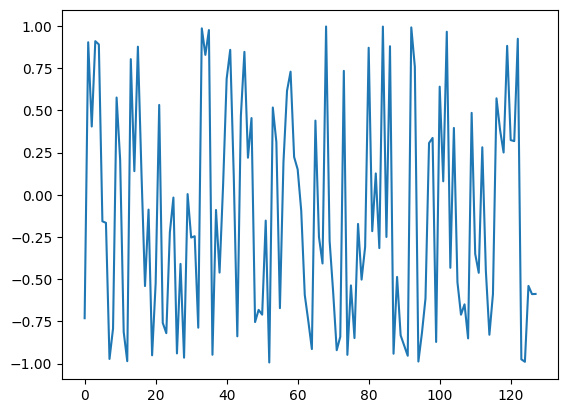

In [117]:
plt.plot(res[0][4].detach().numpy())

In [137]:
class TruckDataset(Dataset):
    def __init__(self,
                df,
                transform=None,
                shuffle_data=True,
                use_rcnn=True):

        self.df = df
        self.transform = transform
        self.use_rcnn = use_rcnn

        if shuffle_data:
            self.df = self.df.sample(frac=1).reset_index(drop=True)



    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx) -> tuple:
        image = Image.open(self.df.iloc[idx, 0]).convert("RGB")
        
        if self.use_rcnn:
            image = extract_trucks(rcnn, image, self.transform)
        else:
            if self.transform:
                image = self.transform(image)
        
        data = pd.read_csv(self.df.iloc[idx, 1])
        data.columns = headers.columns
        data = data[['Sum of strains mid span', ' TC1', ' TC2', ' TC3', ' TC4']]
        data = torch.from_numpy(np.array(data)).type(torch.float32)

        return image, data

In [138]:
tr_dt = TruckDataset(df, transform=data_transforms['train'], use_rcnn=False)
ts_dt = TruckDataset(df, transform=data_transforms['other'], use_rcnn=False)


dt_size = len(tr_dt)
indices = list(range(dt_size))
split_idx = int(SPLIT_PERCENT * dt_size)

tr_indices, ts_indices = indices[:split_idx], indices[split_idx:]

# train_sampler = SubsetRandomSampler(train_indices)
# val_sampler = SubsetRandomSampler(val_indices)

tr_sampler = SubsetRandomSampler(tr_indices)
ts_sampler = SubsetRandomSampler(ts_indices)

tr_loader = DataLoader(tr_dt, batch_size=BATCH_SIZE, sampler=tr_sampler)
# val_loader = DataLoader(val_dt, batch_size=BATCH_SIZE, sampler=val_sampler)
ts_loader = DataLoader(ts_dt, batch_size=BATCH_SIZE, sampler=ts_sampler)

In [139]:
X, y = next(iter(tr_loader))
X.shape, y.shape

(torch.Size([16, 3, 448, 448]), torch.Size([16, 1999, 5]))

In [140]:
# exmple_img_path = df.iloc[74][0]
# print(exmple_img_path)
# image = Image.open(exmple_img_path).convert('RGB')

# extract_trucks(rcnn, image).shape
# cv.imshow('image', extract_trucks(rcnn, image))
# cv.waitKey(0)
# cv.destroyAllWindows()

In [141]:
# img_transformed = data_transforms['rcnn'](image)

In [142]:
# img_transformed.shape

In [143]:
# c, w, h = img_transformed.shape

# res = rcnn(img_transformed.reshape((1, c, w, h)))

In [144]:
# res[0]

In [59]:
# bboxes = res[0]['boxes'].detach()

In [60]:
# bboxes

In [61]:
# exmpl_bbox = np.array(bboxes[0], dtype=int)

In [62]:
# bboxes = [np.array(each, dtype=int) for each in bboxes]
# bboxes = np.array(bboxes)

In [63]:
# bboxes

array([[ 68, 109, 206, 341],
       [ 67, 118, 205, 339],
       [ 20,  87,  25,  92],
       [ 70, 119, 207, 336],
       [ 97, 227, 106, 251]])

In [64]:
# res[0]['labels']

tensor([8, 6, 3, 7, 1])

In [65]:
# img_raw = np.array(data_transforms['rcnn_v'](image))

# # for each_bbox in bboxes:
# #     cv.rectangle(img_raw, (each_bbox[0], each_bbox[1]), (each_bbox[2], each_bbox[3]), (0, 255, 0))
# num = [0, 3]

# for id in num:
#     cv.rectangle(img_raw, (bboxes[id][0], bboxes[id][1]), (bboxes[id][2], bboxes[id][3]), (0, 255, 0), 2)
#     # img_raw_crop = img_raw[bboxes[id][1]: bboxes[id][3], bboxes[id][0]: bboxes[id][2]]
#     print(bboxes[id][2] - bboxes[id][0], bboxes[id][3] - bboxes[id][1])
#     cv.imshow('image', img_raw)
#     cv.waitKey(0)
#     cv.destroyAllWindows()

138 232
137 217
